In [2]:
import pandas as pd
import matplotlib.pyplot as plt

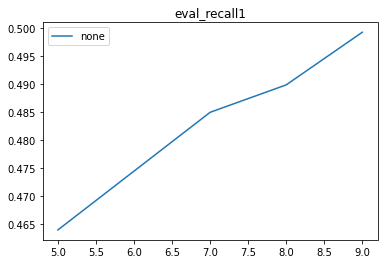

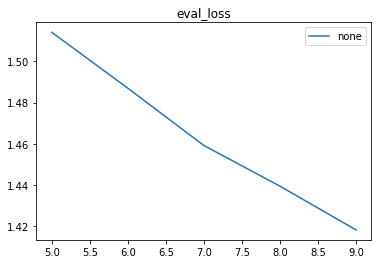

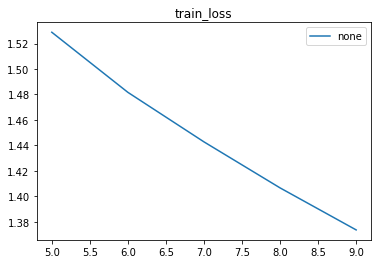

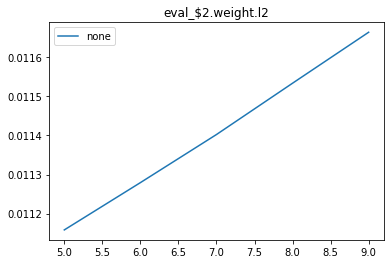

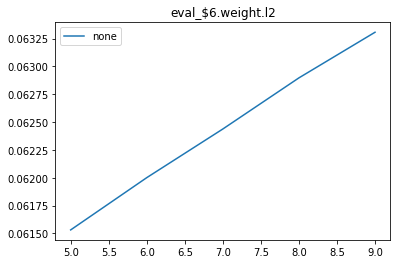

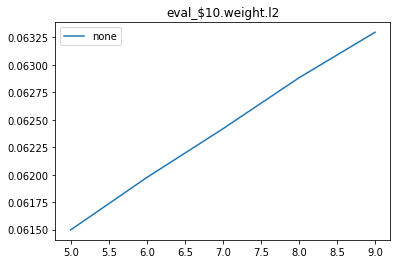

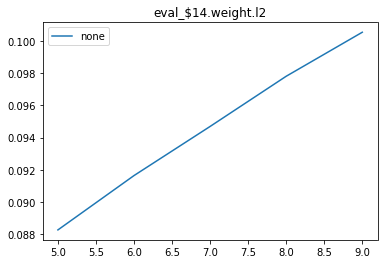

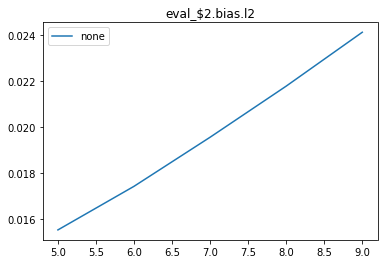

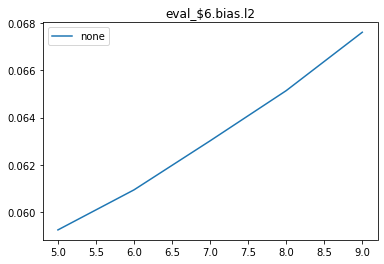

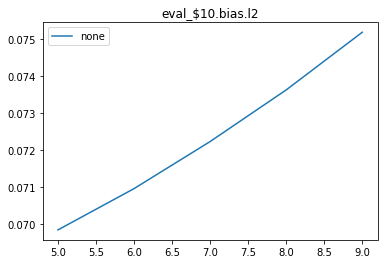

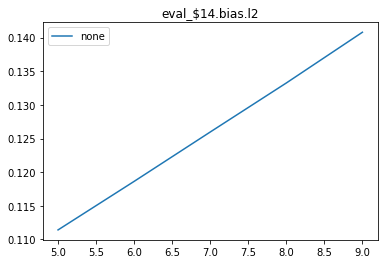

In [3]:
df_map = {}
for tag in ("none", "base", "mean", "cov", "var"):
    try:
        df = pd.read_json(f"outputs/{tag}_1/logs.json")
        df_map[tag] = df
    except:
        pass

def plot(key, start=5):
    _, ax = plt.subplots(1, 1)
    ax.set_title(key)
    for tag, df in df_map.items():
        df[df.index >= start][key].plot(ax=ax, label=tag)
    ax.legend()

plot(f"eval_recall1")
plot(f"eval_loss")
plot(f"train_loss")
for i in (2, 6, 10, 14):
    plot(f"eval_${i}.weight.l2")
for i in (2, 6, 10, 14):
    plot(f"eval_${i}.bias.l2")